# **SASYA**

Music Genre Prediction Model 🎹

In [ ]:
import os
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from keras.models import load_model
import csv


import os
import enum
import glob

import tqdm
import tensorflow as tf
import librosa as lr
import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt

assert tf.__version__ == "2.14.0" and tf.test.is_gpu_available()

# Suppress TensorFlow-related warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# Accessing the dataset through google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
!unzip data1.zip  -d '/content/data1/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
Archive:  data1.zip
   creating: /content/data1/data1/Data/
  inflating: /content/data1/data1/Data/features_3_sec.csv  
  inflating: /content/data1/data1/Data/features_30_sec.csv  
   creating: /content/data1/data1/Data/genres_original/
   creating: /content/data1/data1/Data/genres_original/blues/
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00000.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00001.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00002.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00003.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00004.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00005.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00006.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00007.wav  
  i

In [ ]:
# loading the dataset
data_dir = '/content/data1/data1/Data'
labels=os.listdir(data_dir)
labels

['genres_original',
 'features_30_sec.csv',
 'images_original',
 'features_3_sec.csv']

In [ ]:
# Updating the path to unzipped data directory
data_dir = '/content/data1/data1/Data/genres_original'

# Checking the file paths in the data directory
paths = glob.glob(os.path.join(data_dir, "*/*.wav"))
print("Number of audio files:", len(paths))

# Checking the structure of the data
df = pd.DataFrame({"path": paths})
df["genre"] = df.path.apply(lambda x: x.split("/")[-2])
print(df.head())

Number of audio files: 999
                                                path  genre
0  /content/data1/data1/Data/genres_original/blue...  blues
1  /content/data1/data1/Data/genres_original/blue...  blues
2  /content/data1/data1/Data/genres_original/blue...  blues
3  /content/data1/data1/Data/genres_original/blue...  blues
4  /content/data1/data1/Data/genres_original/blue...  blues


There was a corrupted audio sample in the jazz folder. It was thus eliminated from the dataset before utilisation.

**Genre Vs Duration and Genre vs no. of tracks plot**

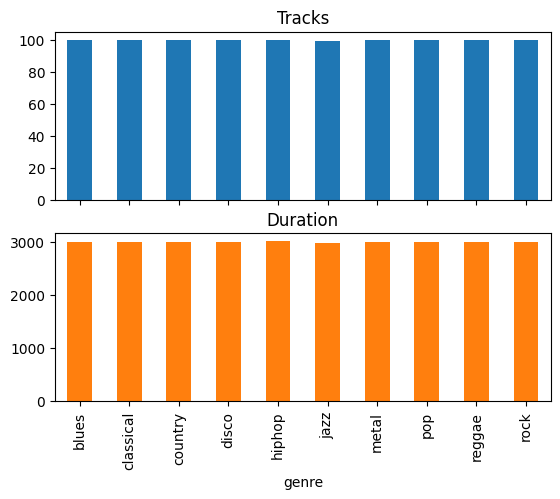

In [ ]:
def load_metadata() -> pd.DataFrame:
    # Updating the path to be relative to the data_dir
    paths = glob.glob(os.path.join(data_dir, "*/*.wav"))
    df = pd.DataFrame({"path": paths})
    df["genre"] = df.path.apply(lambda x: x.rsplit("/")[-2])
    df["duration"] = df.path.apply(lambda x: lr.get_duration(filename=x))
    df["samplerate"] = df.path.apply(lr.get_samplerate)
    return df

metadata = load_metadata()
groups = metadata.groupby("genre")

# Checking if there are any groups in the DataFrameGroupBy
if groups.ngroups > 0:
    pd.DataFrame({
        'Tracks': groups.path.count(),
        'Duration': groups.duration.sum()
    }).plot.bar(subplots=True, legend=None)
else:
    print("No data to plot.")

It is evident from the information, the dataset is initially balanced, eliminating concerns regarding majority/minority genres.

**Sampled signal plot for one of the audio tracks**

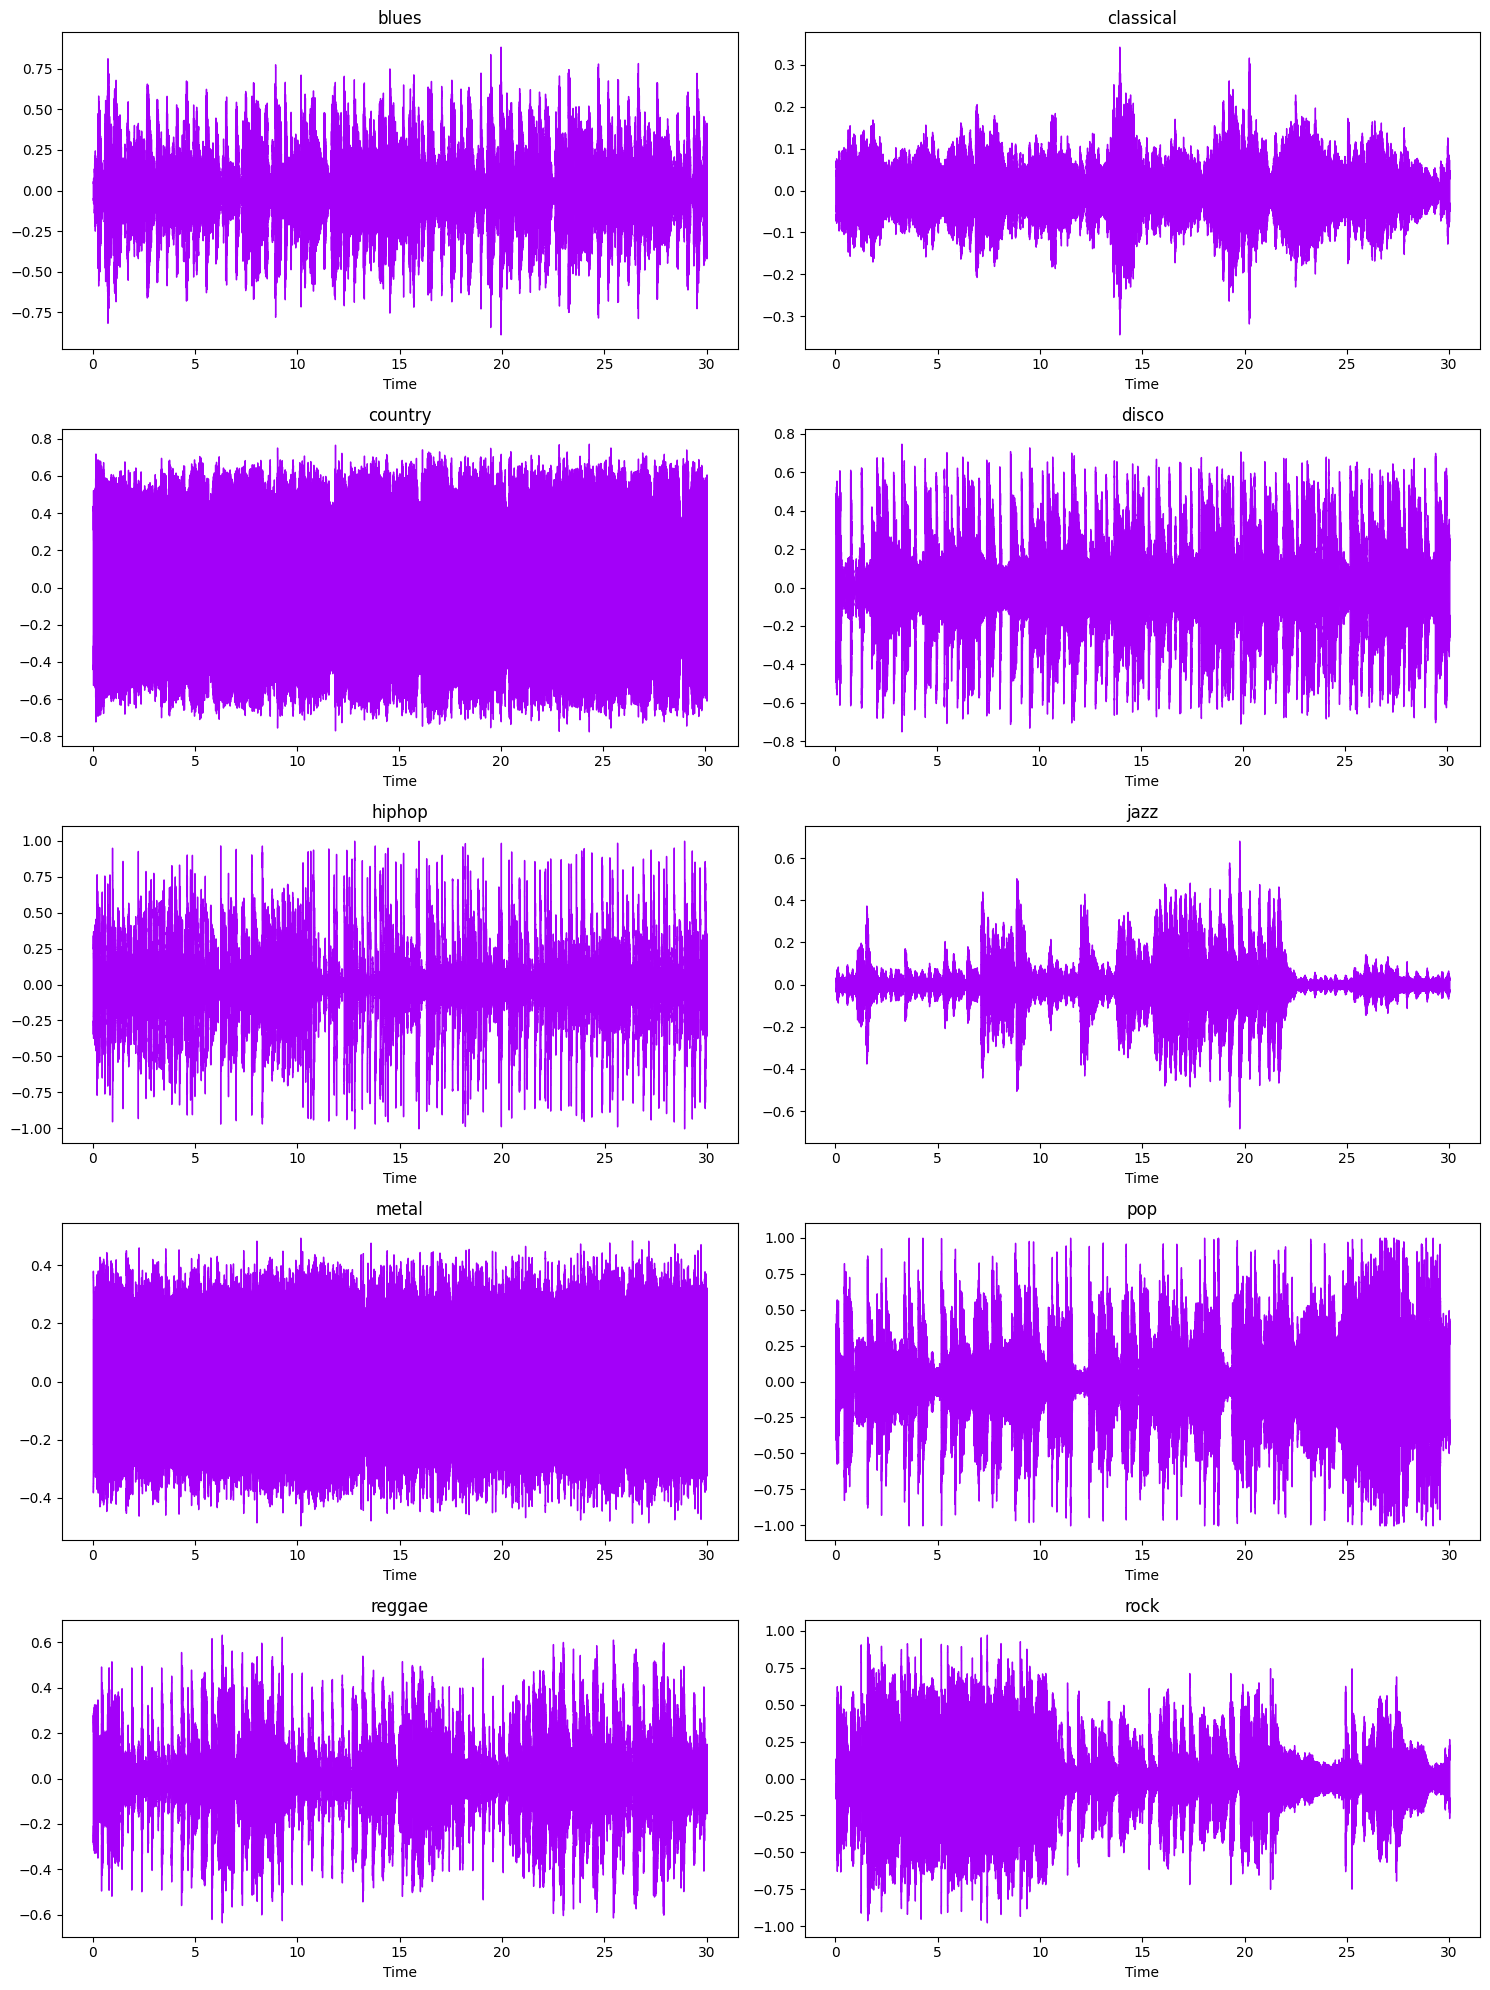

In [ ]:
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}
hop_length = 512

n_fft = 2048

fig, axes= plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
i = 0
j = 0
for genre in genre_dict.keys():
    # Reading the first audio file
    data,sampling_rate = lr.load(data_dir + "/" + genre + "/" + genre + ".00000.wav")

    lr.display.waveshow(y = data, sr = sampling_rate, color = "#A300F9",ax=axes[i][j])


    axes[i][j].set_title(genre)

    if(j == 1):
        i = i + 1
        j = 0
    else:
        j = j + 1

plt.tight_layout()
plt.show()

**Generate and display a spectrogram of the signal 'y' using the 'inferno' colormap.**

In [ ]:
cmap = plt.get_cmap('inferno')
time.sleep(1)

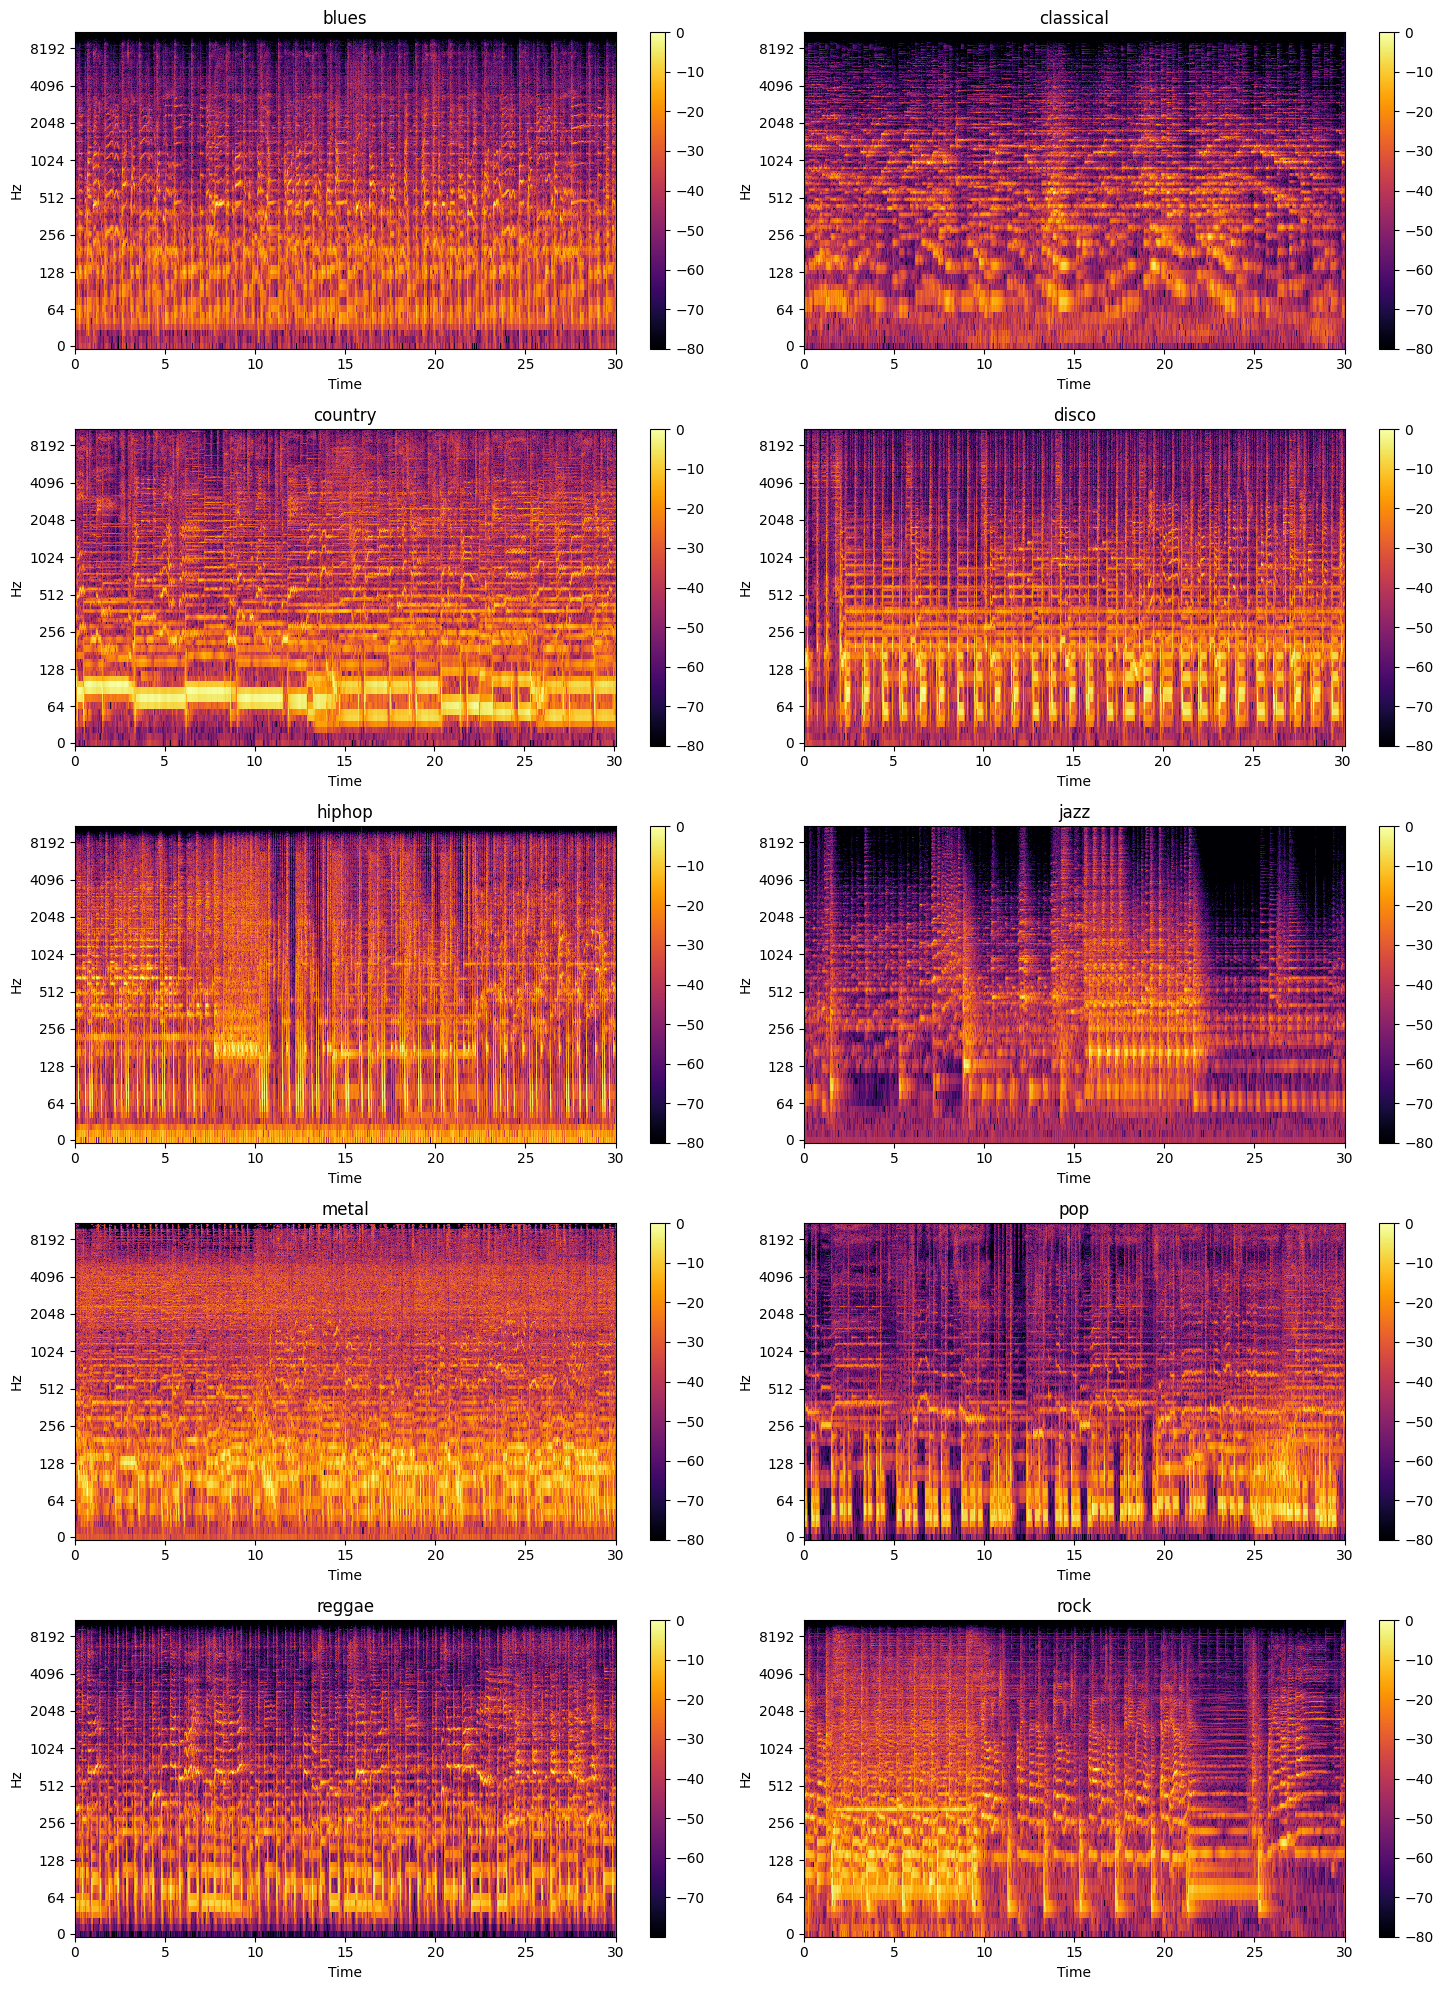

In [ ]:
from pandas.core.reshape.melt import lreshape
#spectrogram stuff
fig, axes= plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
i = 0
j = 0
for genre in genre_dict.keys():
    # Reading the first audio file
    data,sampling_rate = lr.load(data_dir +"/" + genre + "/" + genre + ".00000.wav")

    stft_data = np.abs(lr.stft(y = data, n_fft = n_fft,hop_length = hop_length))

    # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
    DB = lr.amplitude_to_db(stft_data, ref = np.max)

    img = lr.display.specshow(DB, sr = sampling_rate, hop_length = hop_length, x_axis = 'time', y_axis = 'log',cmap = cmap,ax=axes[i][j])
    fig.colorbar(img, ax=axes[i][j])

    axes[i][j].set_title(genre)

    if(j == 1):
        i = i + 1
        j = 0
    else:
        j = j + 1

plt.tight_layout()
plt.show()


**Extract audio features from music files of various genres and save the data in a CSV file**

In [ ]:
# genres_directory = os.path.join(data_dir, 'genres_original')
genres_directory = data_dir

header = 'filename chroma_stft_mean chroma_stft_var rmse_mean rmse_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var tempo_mean tempo_var'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
count = 0


for genre in genres:
    genre_directory = os.path.join(genres_directory, genre)
    for filename in os.listdir(genre_directory):
        songname = os.path.join(genre_directory, filename)
        # sampling of the input
        y, sr = lr.load(songname, duration=30)
        # parameter extraction
        chroma_stft = lr.feature.chroma_stft(y=y, sr=sr)
        rmse = lr.feature.rms(y=y)
        spec_cent = lr.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = lr.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = lr.feature.spectral_rolloff(y=y, sr=sr)
        zcr = lr.feature.zero_crossing_rate(y)
        tempo = lr.feature.tempo(y=y, sr=sr)
        mfcc = lr.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # preparing an input row for csv
        to_append = f'{filename} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rmse)} {np.var(rmse)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {np.mean(tempo)} {np.var(tempo)}'
        for e in mfcc:
            to_append += f' {np.mean(e)} {np.var(e)}'
        to_append += f' {genre}'

        count += 1
        print(f'{count}-{to_append}')

        # writing into csv
        with open('data.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

data = pd.read_csv('data.csv')


1-blues.00045.wav 0.42972081899642944 0.09001430869102478 0.14830446243286133 0.0007087622652761638 1739.0461604116053 144992.5443755812 2290.4006079789 65425.45146138434 4551.180812965606 820305.3257412933 0.048051863631965945 0.0002663457698385263 129.19921875 0.0 -163.24313354492188 670.504638671875 89.7848892211914 207.69918823242188 12.977463722229004 135.02102661132812 80.69248962402344 43.340576171875 3.666778326034546 32.88131332397461 39.74512481689453 38.83115005493164 -5.400375843048096 43.94953536987305 26.49867057800293 31.576736450195312 -13.163734436035156 37.96630096435547 2.7070107460021973 35.91717529296875 -20.552906036376953 38.922813415527344 6.0071868896484375 37.751041412353516 -2.9081296920776367 50.26584243774414 -0.4348372220993042 31.98988914489746 -17.54537010192871 38.859397888183594 4.1541666984558105 31.966548919677734 -5.9900970458984375 36.06646728515625 -7.862037181854248 31.966476440429688 -8.565293312072754 31.824987411499023 1.8571702241897583 42.82

**Encode the genre labels using LabelEncoder and obtain the shape and first five encoded values**

In [ ]:
genre_list = data.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
y.shape , y[:5]


((999,), array([0, 0, 0, 0, 0]))

In [ ]:
data1 = data.drop(['filename','label'],axis=1)
data1

chroma_stft_mean  chroma_stft_var  rmse_mean  rmse_var  \
0            0.429721         0.090014   0.148304  0.000709   
1            0.404848         0.094018   0.141139  0.006340   
2            0.291406         0.094003   0.141688  0.008783   
3            0.421949         0.092692   0.099380  0.001286   
4            0.278666         0.095020   0.076939  0.005918   
..                ...              ...        ...       ...   
994          0.436834         0.086589   0.148552  0.006557   
995          0.398761         0.075115   0.076425  0.000590   
996          0.408423         0.089056   0.089477  0.001475   
997          0.356773         0.089102   0.106816  0.000787   
998          0.358165         0.085806   0.054442  0.000337   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1739.046160          144992.544376              2290.400608   
1               1070.110059          184506.655476              1596.244204   
2               1459.035376          438118.032075              1388.725515   
3                991.150253          416147.951083              1396.261954   
4               1198.754499          161883.034798              1573.085113   
..                      ...                    ...                      ...   
994             1874.829787          469436.085086              1984.057193   
995             2006.009248          181437.001000              2068.224879   
996             2591.116791          305963.264219              2078.651677   
997             2581.809229          418450.761976              2376.373190   
998             1609.369937          422427.986862              1796.923716   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0              65425.451461   4551.180813  8.203053e+05  ...     4.154167   
1             166637.568358   2185.061787  1.494194e+06  ...     0.776909   
2             185132.013201   2795.674762  1.622691e+06  ...   -10.071382   
3             262404.066162   1943.288249  2.279041e+06  ...    -2.872343   
4              83785.469986   2478.826678  9.916715e+05  ...     3.260078   
..                      ...           ...           ...  ...          ...   
994           168408.380748   3929.976236  2.041989e+06  ...     5.470715   
995            81920.961412   4147.166589  1.041906e+06  ...     3.738004   
996            77151.814534   4889.828765  9.488313e+05  ...     0.666676   
997            64752.387134   5391.134067  1.148595e+06  ...     6.212512   
998           120303.322528   3246.305370  1.754290e+06  ...     1.788250   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     31.966549    -5.990097   36.066467    -7.862037   31.966476   
1     44.456993    -3.320055   50.236973     0.637263   37.351921   
2     83.322792   -10.912119   56.937706    -6.970003   38.267601   
3     46.778740    -3.758526   36.210575    -3.345786   45.862556   
4    115.498260    -4.558311  137.147202     0.478019  105.822777   
..          ...          ...         ...          ...         ...   
994   32.879963    -2.239539   46.010559     1.057280   48.170864   
995   33.877960   -10.854526   39.240730     1.872499   32.014000   
996   49.089191    -6.794241   68.316177     4.464340   89.525635   
997   40.992043    -7.955031   50.291615     7.708114   82.072792   
998   59.109993    -7.072692   73.692841     0.021304   76.548775   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0      -8.565293   31.824987     1.857170   42.829807  
1      -0.617507   37.291168    -3.406940   31.988445  
2      -3.448513   48.093582    -6.498457   70.019577  
3      -2.416106   45.684563    -3.783830   40.279102  
4       5.929787  140.536789     3.228341  169.687820  
..           ...         ...          ...         ...  
994    -1.651923   32.450871    -0.042326   31.209723  
995    -7.467166   39.204884    -2.797983   31.698040  
996     0.237279   94.972710     0.433764

**Standardize the features in 'data1' using StandardScaler and store the standardized data in 'x'**

In [ ]:
scaler = StandardScaler()

x = scaler.fit_transform(np.array(data1,dtype = float))
x

array([[ 6.23750193e-01,  4.73571110e-01,  2.65969875e-01, ...,
        -9.25165207e-01,  7.69178542e-01, -6.02397700e-01],
       [ 3.19096519e-01,  9.90763854e-01,  1.56829049e-01, ...,
        -7.78178148e-01, -6.02524250e-01, -8.42148082e-01],
       [-1.07042031e+00,  9.88792724e-01,  1.65186680e-01, ...,
        -4.87698358e-01, -1.40810068e+00, -1.11183847e-03],
       ...,
       [ 3.62886775e-01,  3.49778712e-01, -6.30092444e-01, ...,
         7.72893878e-01,  3.98272501e-01,  7.97072917e-01],
       [-2.69760336e-01,  3.55754665e-01, -3.65978984e-01, ...,
         3.44271579e-01,  4.22472687e-01, -4.59226550e-01],
       [-2.52711628e-01, -7.00625039e-02, -1.16373712e+00, ...,
         1.60217519e-01,  5.86435635e-01, -4.49764502e-01]])

**splitting the data**

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(x,y,test_size=0.20)
print(f'X_train : {X_train.shape} , X_test : {X_test.shape} , y_train : {y_train.shape} , y_test : {y_test.shape}')

X_train : (799, 54) , X_test : (200, 54) , y_train : (799,) , y_test : (200,)


**Using KNN (model 0)**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f'Accuracy: {accuracy_knn * 100:.2f}%')

Accuracy: 58.00%


**Using SVM(Model 1)**

In [ ]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred1 = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)

# Print a classification report
print(classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

           0       0.67      0.64      0.65        28
           1       0.80      0.73      0.76        11
           2       0.67      0.65      0.66        31
           3       0.57      0.48      0.52        27
           4       0.50      0.53      0.52        15
           5       0.78      0.74      0.76        19
           6       0.77      0.91      0.83        22
           7       0.62      0.87      0.72        15
           8       0.50      0.46      0.48        13
           9       0.47      0.42      0.44        19

    accuracy                           0.64       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.64      0.64      0.64       200



**Ensemble of SVMs(Model2)**

In [ ]:
# Creating individual SVM classifiers with different hyperparameters
svm_classifier_1 = SVC(kernel='linear', C=1.0)
svm_classifier_2 = SVC(kernel='rbf', C=1.0, gamma=0.001)
svm_classifier_3 = SVC(kernel='poly', C=1.0, degree=3)

# Creating a voting ensemble classifier
ensemble_classifier = VotingClassifier(estimators=[
    ('svm_linear', svm_classifier_1),
    ('svm_rbf', svm_classifier_2),
    ('svm_poly', svm_classifier_3)
], voting='hard')  # 'hard' for majority class voting, 'soft' for probability-based voting

# Training the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Making predictions using the ensemble classifier
y_pred2 = ensemble_classifier.predict(X_test)

# Calculating accuracy
accuracy1 = accuracy_score(y_test, y_pred2)

# Printing a classification report
print(classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.68      0.61      0.64        28
           1       0.73      1.00      0.85        11
           2       0.77      0.65      0.70        31
           3       0.54      0.48      0.51        27
           4       0.55      0.40      0.46        15
           5       0.92      0.63      0.75        19
           6       0.80      0.91      0.85        22
           7       0.55      0.73      0.63        15
           8       0.56      0.38      0.45        13
           9       0.34      0.58      0.43        19

    accuracy                           0.63       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.65      0.63      0.63       200



**CNN(Model 3)**

In [ ]:
model3 = models.Sequential([

layers.Dense(256 , activation = 'relu' , input_shape=(X_train.shape[1],)),
layers.Dropout(0.5),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(10 , activation = 'softmax')

])

model3.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model3.fit(X_train,y_train,epochs=500,batch_size=128)

test_loss3 , test_acc3 = model3.evaluate(X_test,y_test)

Epoch 1/500
7/7 [==============================] - 7s 6ms/step - loss: 2.5614 - accuracy: 0.1014
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 2.3447 - accuracy: 0.1452
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 2.1808 - accuracy: 0.2028
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 2.1044 - accuracy: 0.2403
Epoch 5/500
7/7 [==============================] - 0s 5ms/step - loss: 2.0721 - accuracy: 0.2603
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 1.9552 - accuracy: 0.3054
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 1.9095 - accuracy: 0.3191
Epoch 8/500
7/7 [==============================] - 0s 5ms/step - loss: 1.8923 - accuracy: 0.3191
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 1.8259 - accuracy: 0.3279
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 1.8039 - accuracy: 0.3567
Epoch 11/500
7/7 [===========

**CNN(Model 4)**

In [ ]:
import tensorflow.keras as keras

# Build network topology
model4 = keras.Sequential()

# Input shape should be (num_features, 1)
input_shape = (X_train.shape[1], 1)

# 1st conv layer
model4.add(keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
model4.add(keras.layers.MaxPooling1D(3, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# 2nd conv layer
model4.add(keras.layers.Conv1D(32, 3, activation='relu'))
model4.add(keras.layers.MaxPooling1D(3, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# 3rd conv layer
model4.add(keras.layers.Conv1D(32, 2, activation='relu'))
model4.add(keras.layers.MaxPooling1D(2, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# Flatten output and feed it into dense layer
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(64, activation='relu'))
model4.add(keras.layers.Dropout(0.3))

# Output layer with the number of music genres as the number of units
num_music_genres = 10  # Adjust this based on your dataset
model4.add(keras.layers.Dense(num_music_genres, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model4.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model4.fit(X_train, y_train, batch_size=128, epochs=500)

Epoch 1/500
7/7 [==============================] - 8s 28ms/step - loss: 2.7653 - accuracy: 0.1101
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 2.7194 - accuracy: 0.1176
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 2.6117 - accuracy: 0.1264
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 2.5244 - accuracy: 0.1514
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 2.4754 - accuracy: 0.1665
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 2.3687 - accuracy: 0.1752
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 2.3645 - accuracy: 0.2040
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 2.2707 - accuracy: 0.2115
Epoch 9/500
7/7 [==============================] - 0s 7ms/step - loss: 2.1918 - accuracy: 0.2165
Epoch 10/500
7/7 [==============================] - 0s 7ms/step - loss: 2.1723 - accuracy: 0.2478
Epoch 11/500
7/7 [==========

In [ ]:
test_loss4 , test_acc4 = model4.evaluate(X_test,y_test)

7/7 [==============================] - 1s 18ms/step - loss: 1.6062 - accuracy: 0.5450


**CNN(Model 5)**

In [ ]:
model5 = models.Sequential([

layers.Dense(1024 , activation = 'relu' , input_shape=(X_train.shape[1],)),
layers.Dropout(0.3),

layers.Dense(512 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(256 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(32 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(10 , activation = 'softmax')

])

model5.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model5.fit(X_train,y_train,epochs=500,batch_size=128)

test_loss5 , test_acc5 = model5.evaluate(X_test,y_test)

Epoch 1/500
7/7 [==============================] - 3s 8ms/step - loss: 2.3114 - accuracy: 0.1051
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 2.2454 - accuracy: 0.1715
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 2.1896 - accuracy: 0.2028
Epoch 4/500
7/7 [==============================] - 0s 5ms/step - loss: 2.0981 - accuracy: 0.2528
Epoch 5/500
7/7 [==============================] - 0s 5ms/step - loss: 2.0191 - accuracy: 0.2954
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 1.8736 - accuracy: 0.3467
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 1.8240 - accuracy: 0.3554
Epoch 8/500
7/7 [==============================] - 0s 5ms/step - loss: 1.6977 - accuracy: 0.4080
Epoch 9/500
7/7 [==============================] - 0s 5ms/step - loss: 1.6144 - accuracy: 0.4355
Epoch 10/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5890 - accuracy: 0.4443
Epoch 11/500
7/7 [===========

The five models above are based on the 30 second audio files of the dataset.
Individual validation accuracy rates stand as:
1. KNN :64.5
2. SVM :67
3. Ensemble of SVM :64
4. CNN_1 :74
5. CNN_2 :61
6. CNN_3 :69.5

However, since the dataset is only of 999 cases, to extend the dataset, each of the 30 second clips are further chooped to 3 second clips to give approximately 10000 labelled audio clips and the following procedure is administered.

**Using features_3_sec.csv file**

In [ ]:
music_data = pd.read_csv('/content/data1/data1/Data/features_3_sec.csv')
music_data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [ ]:
columns = music_data.columns
columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [ ]:
music_data = music_data.drop(labels = 'filename', axis = 1)
dup_rows = music_data[music_data.duplicated()]
print("Duplicate Rows :")
print(dup_rows)

Duplicate Rows :
      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
3984   66149          0.457339         0.080025  0.126573  0.001655   
3985   66149          0.461702         0.076551  0.126689  0.001306   
3986   66149          0.465382         0.082425  0.126063  0.002052   
3987   66149          0.499932         0.075785  0.121706  0.001185   
3988   66149          0.491556         0.080853  0.112325  0.001710   
...      ...               ...              ...       ...       ...   
8817   66149          0.480196         0.092766  0.181527  0.009155   
8818   66149          0.496611         0.093527  0.173489  0.010961   
8819   66149          0.504368         0.092385  0.187114  0.010748   
8820   66149          0.476700         0.085658  0.164774  0.007827   
8821   66149          0.485232         0.087667  0.189201  0.011347   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
3984             2322.659630           7.367283e+0

In [ ]:
music_data = music_data.drop_duplicates()
music_data.shape

(9857, 59)

In [ ]:
music_data['label'].value_counts()

blues        1000
jazz         1000
classical     998
rock          998
country       997
disco         989
reggae        987
pop           980
hiphop        978
metal         930
Name: label, dtype: int64

In [ ]:
# Transforming Features
class_list = music_data.iloc[:, -1]
convertor = LabelEncoder()
y_1 = convertor.fit_transform(class_list)
y_1

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
# Scaling of Features
fit = StandardScaler()
X_1 = fit.fit_transform(np.array(music_data.iloc[:, :-1], dtype = float))
X_1

array([[ 0.        , -0.47823418,  0.64103381, ..., -0.51237921,
         0.12884682, -0.29173101],
       [ 0.        , -0.39367631,  0.13101707, ...,  1.00956355,
         1.27168611,  0.05527452],
       [ 0.        , -0.35228163,  0.76532861, ..., -0.04598171,
         0.65226613, -0.52061685],
       ...,
       [ 0.        , -0.3449272 ,  0.4299367 , ..., -0.15322724,
         0.11812995, -0.33861214],
       [ 0.        ,  0.09719913, -0.00748043, ..., -0.7229713 ,
         0.30307665, -0.95658885],
       [ 0.        , -0.10411463,  0.1947118 , ..., -0.37154794,
        -0.47214596, -0.55017821]])

In [ ]:
# splittinf the data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.2)
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((7885, 58), (1972, 58), (7885,), (1972,))

### KNN (Model 0)

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_1.fit(X_train_1, y_train_1)

y_pred_knn_1 = knn_1.predict(X_test_1)
accuracy_knn_1 = accuracy_score(y_test_1, y_pred_knn_1)

print(f'Accuracy: {accuracy_knn_1 * 100:.2f}%')

Accuracy: 87.47%


### CNN (Model 1)

In [ ]:
from keras import models
from keras import layers

model_n = models.Sequential([

layers.Dense(256 , activation = 'relu' , input_shape=(X_train_1.shape[1],)),
layers.Dropout(0.5),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(10 , activation = 'softmax')

])

model_n.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model_n.fit(X_train_1,y_train_1,epochs=500,batch_size=128)

test_loss_n , test_acc_n = model_n.evaluate(X_test_1,y_test_1)

Epoch 1/500
62/62 [==============================] - 1s 3ms/step - loss: 2.1956 - accuracy: 0.2129
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 1.8079 - accuracy: 0.3377
Epoch 3/500
62/62 [==============================] - 0s 5ms/step - loss: 1.6177 - accuracy: 0.4080
Epoch 4/500
62/62 [==============================] - 0s 5ms/step - loss: 1.5046 - accuracy: 0.4483
Epoch 5/500
62/62 [==============================] - 0s 5ms/step - loss: 1.4047 - accuracy: 0.4968
Epoch 6/500
62/62 [==============================] - 0s 4ms/step - loss: 1.3077 - accuracy: 0.5344
Epoch 7/500
62/62 [==============================] - 0s 5ms/step - loss: 1.2383 - accuracy: 0.5636
Epoch 8/500
62/62 [==============================] - 0s 5ms/step - loss: 1.1708 - accuracy: 0.5885
Epoch 9/500
62/62 [==============================] - 0s 5ms/step - loss: 1.1471 - accuracy: 0.6065
Epoch 10/500
62/62 [==============================] - 0s 5ms/step - loss: 1.1015 - accuracy: 0.6217
Epoch 11/

In [ ]:
model_n.save('final_model.h5')

The CNN Model was observed to give the best accuracy of 91.08 percentage when executed on 3 sec audio samples.

In [ ]:
# Loading Testing Data
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
!unzip test_audio.zip  -d '/content/test_audio/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks
Archive:  test_audio.zip
  inflating: /content/test_audio/test_audio/blues.wav  
  inflating: /content/test_audio/test_audio/jazz.wav  
  inflating: /content/test_audio/test_audio/pop.wav  


In [ ]:
def extract_features_and_predict(test_directory, model_path):
    # Load the saved model
    loaded_model = load_model(model_path)

    # Path to the CSV file where the features will be stored
    csv_file_path = 'test_data.csv'

    header = 'filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var mfcc5_mean mfcc5_var mfcc6_mean mfcc6_var mfcc7_mean mfcc7_var mfcc8_mean mfcc8_var mfcc9_mean mfcc9_var mfcc10_mean mfcc10_var mfcc11_mean mfcc11_var mfcc12_mean mfcc12_var mfcc13_mean mfcc13_var mfcc14_mean mfcc14_var mfcc15_mean mfcc15_var mfcc16_mean mfcc16_var mfcc17_mean mfcc17_var mfcc18_mean mfcc18_var mfcc19_mean mfcc19_var mfcc20_mean mfcc20_var label'
    header = header.split()

    file = open(csv_file_path, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)

    count = 0

    # Iterate through each test audio file in the specified directory
    for filename in os.listdir(test_directory):
        file_path = os.path.join(test_directory, filename)

        try:
            # Sampling of the input
            y, sr = lr.load(file_path, duration=30)

            # Parameter extraction
            chroma_stft = lr.feature.chroma_stft(y=y, sr=sr)
            rms = lr.feature.rms(y=y)
            spectral_centroid = lr.feature.spectral_centroid(y=y, sr=sr)
            spectral_bandwidth = lr.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = lr.feature.spectral_rolloff(y=y, sr=sr)
            zero_crossing_rate = lr.feature.zero_crossing_rate(y)
            harmony, perceptr = lr.effects.harmonic(y), lr.effects.percussive(y)

            # Corrected usage of beat_track
            onset_env = lr.onset.onset_strength(y=y, sr=sr)
            tempo, _ = lr.beat.beat_track(onset_envelope=onset_env, sr=sr)

            mfccs = lr.feature.mfcc(y=y, sr=sr, n_mfcc=20)

            # Flatten the features
            features = [filename, len(y)]
            features += [np.mean(chroma_stft), np.var(chroma_stft)]
            features += [np.mean(rms), np.var(rms)]
            features += [np.mean(spectral_centroid), np.var(spectral_centroid)]
            features += [np.mean(spectral_bandwidth), np.var(spectral_bandwidth)]
            features += [np.mean(rolloff), np.var(rolloff)]
            features += [np.mean(zero_crossing_rate), np.var(zero_crossing_rate)]
            features += [np.mean(harmony), np.var(harmony)]
            features += [np.mean(perceptr), np.var(perceptr)]
            features += [tempo]

            for mfcc in mfccs:
                features += [np.mean(mfcc), np.var(mfcc)]

            # Preparing an input row for CSV
            to_append = ' '.join(map(str, features)) + ' unknown'

            count += 1
            # print(f'{count}-{to_append}')

            # Writing into CSV
            with open(csv_file_path, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Load the extracted features into a DataFrame
    df_test = pd.read_csv(csv_file_path)

    # Exclude non-numeric columns ('filename' and 'label')
    numeric_columns = df_test.select_dtypes(include=[np.number]).columns
    X_features = df_test[numeric_columns]

    # Initialize the StandardScaler
    fit = StandardScaler()

    # Fit and transform the selected features
    X_final = fit.fit_transform(X_features)
    predictions = loaded_model.predict(X_final)
    average_probabilities = np.mean(predictions, axis=0)
    average_probabilities = average_probabilities * 100

    # Define probability ranges
    ranges = [(75, 100), (50, 75), (25, 50)]

    # Assign labels based on probability ranges
    labels = np.zeros_like(average_probabilities, dtype=int)

    # Assign labels based on probability ranges
    for i, (lower, upper) in enumerate(ranges):
        condition = (average_probabilities >= lower) & (average_probabilities <= upper)
        labels[condition] = 3 - i

    return labels

# Example usage:
test_directory = '/content/test_audio/test_audio'
model_path = 'final_model.h5'
assigned_labels = list(extract_features_and_predict(test_directory, model_path))
print("Assigned Labels:", assigned_labels)


1/1 [==============================] - 0s 131ms/step
Assigned Labels: [1 0 1 0 0 0 0 0 0 0]
